In [1]:
import os
os.chdir('..')

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from matplotlib import pyplot as plt

In [3]:
train_split_featurized = pd.read_parquet(".data/train_split_featurized.parquet")
_test_split_featurized = pd.read_parquet(".data/test_split_featurized.parquet")
test_split_featurized = pd.concat([train_split_featurized, _test_split_featurized], axis=0) 

In [4]:
def create_time_sequence_vectors(df: pd.DataFrame, maxlen: int, target_month: int) -> np.ndarray:
    target_index = df['date_block_num'] == target_month
    x = df[~target_index]
    y = df[target_index]

    if y.empty:
        y = [np.nan]
    else:
        y = y['item_cnt_month'].values
    
    v = np.zeros(maxlen)
    x['date_block_num'] = x['date_block_num'].astype(int)
    v[x['date_block_num'].values] = x['item_cnt_month'].values

    return pd.DataFrame({'monthly_sales_array': [v], 'y': y})

def transform_data_to_features(df: pd.DataFrame, max_seq_len: int) -> pd.DataFrame:
    target_month = df['date_block_num'].max()

    df = df.merge(
        df[df.date_block_num == target_month][['shop_id', 'item_id']],
        on=['shop_id', 'item_id'],
        how='right'    
    )
    
    padded_seqs = df.groupby(["shop_id", "item_id"]) \
        .apply(create_time_sequence_vectors, maxlen=max_seq_len, target_month=target_month) \
        .reset_index() \
        .rename(columns={0: 'monthly_sales_array'}, inplace=False) \
        .drop(columns=['level_2'])
    
    return padded_seqs

df_train_vectors = transform_data_to_features(train_split_featurized, 35)
df_val_vectors = transform_data_to_features(test_split_featurized, 35)

/var/folders/nn/v5bcwy852z121w7pz8m7sypr0000gn/T/ipykernel_32492/2025639828.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  padded_seqs = df.groupby(["shop_id", "item_id"]) \
/var/folders/nn/v5bcwy852z121w7pz8m7sypr0000gn/T/ipykernel_32492/2025639828.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  padded_seqs = df.groupby(["shop_id", "item_id"]) \


In [5]:
df_train = df_train_vectors.merge(pd.read_csv(".data/items.csv")[['item_id', 'item_category_id']], on='item_id', how='left')
df_val = df_val_vectors.merge(pd.read_csv(".data/items.csv")[['item_id', 'item_category_id']], on='item_id', how='left')

In [ ]:
df_train['y'] = df_train['y'].clip(0, 20)
df_val['y'] = df_val['y'].clip(0, 20)

In [6]:
class SalesDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.shop_ids = torch.tensor(self.df['shop_id'].values, dtype=torch.long).unsqueeze(1)
        self.item_ids = torch.tensor(self.df['item_id'].values, dtype=torch.long).unsqueeze(1)
        self.category_ids = torch.tensor(self.df['item_category_id'].values, dtype=torch.long).unsqueeze(1)
        self.sales_array = torch.tensor(np.vstack(self.df['monthly_sales_array'].values), dtype=torch.float32).unsqueeze(2)
        self.targets = torch.tensor(self.df['y'].values, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        return (self.shop_ids[idx], self.item_ids[idx], self.category_ids[idx], self.sales_array[idx], self.targets[idx])


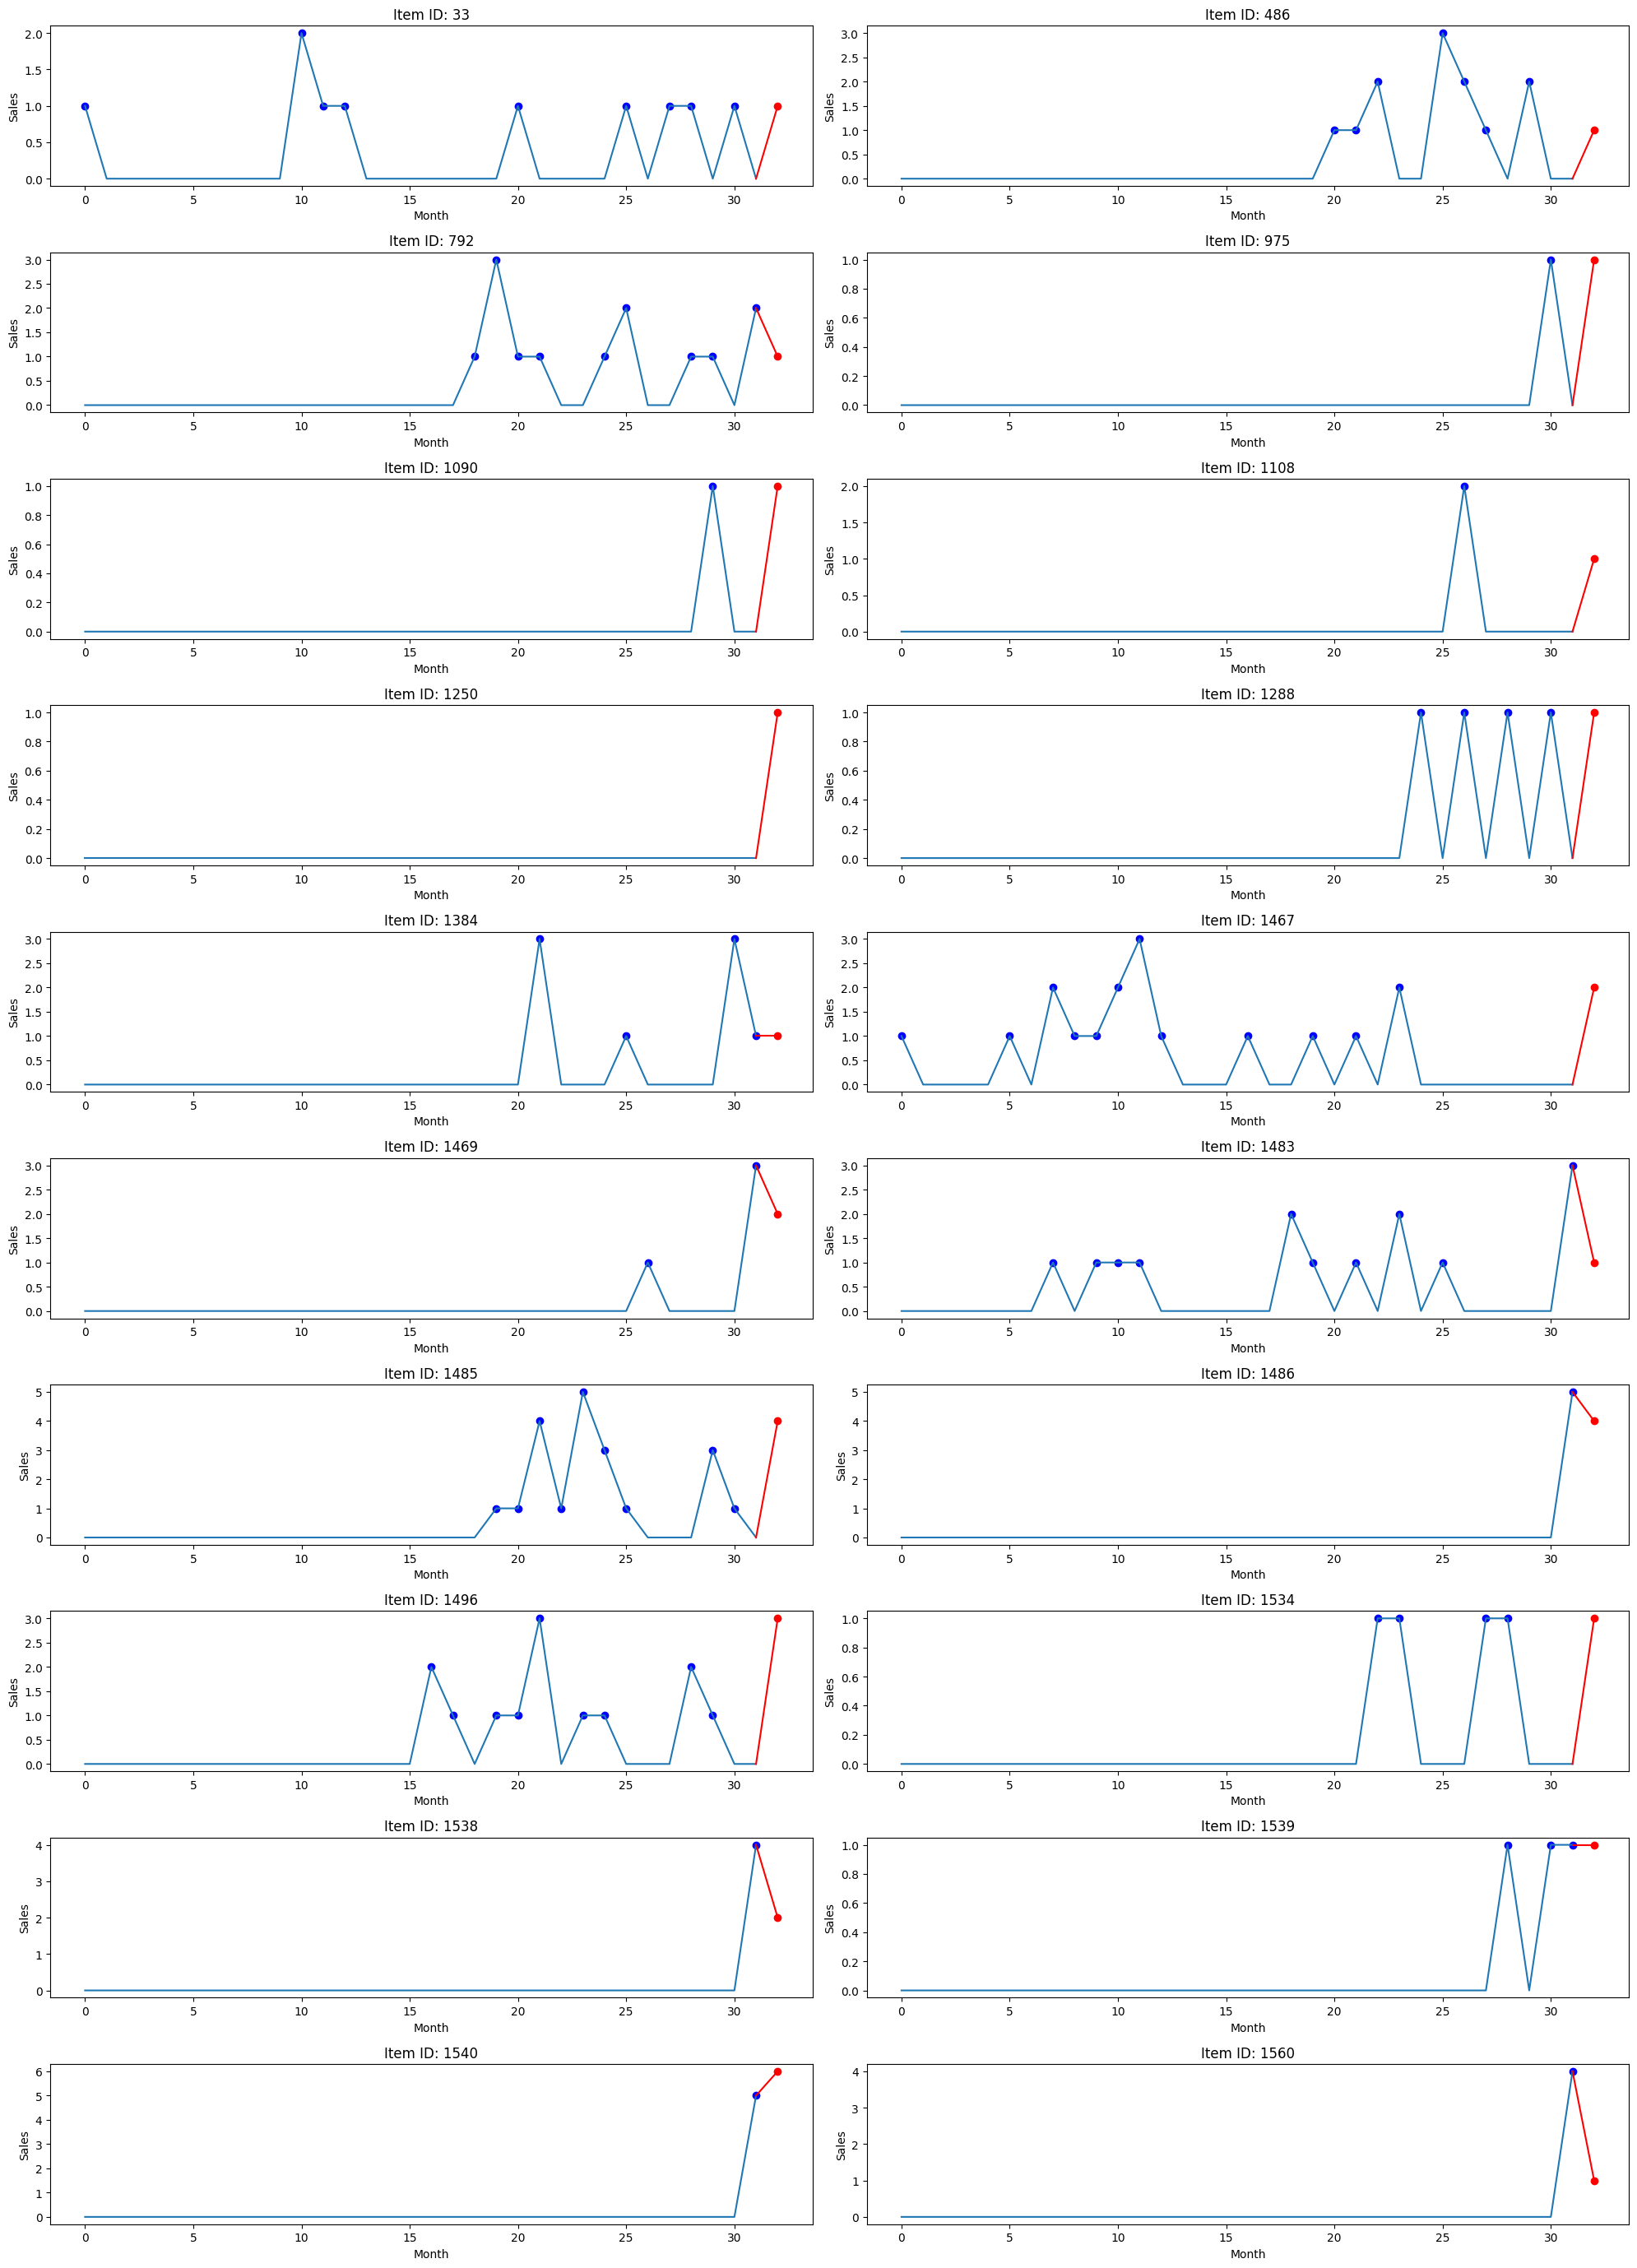

In [34]:
df_shop_2 = df_train[df_train['shop_id'] == 2].head(20)

# Set up the plot
plt.figure(figsize=(20, 30))

# Iterate over the rows and plot the monthly_sales_array for each item_id
for i, (_, row) in enumerate(df_shop_2.iterrows(), 1):
    
    sales_array = row.monthly_sales_array[:32]
    
    plt.subplot(len(df_shop_2) // 2 + 1, 2, i)
    plt.plot(sales_array, label='Sales')

    non_zero_values = np.where(sales_array != 0)[0]
    plt.scatter(non_zero_values, sales_array[non_zero_values], color='blue')

    # Plot the continuation to the target value
    plt.plot([31, 32], [sales_array[-1], row.y], color='red')
    plt.scatter(32, row.y, color='red', label='Target')
    
    plt.title(f'Item ID: {row.item_id}')
    plt.xlabel('Month')
    plt.ylabel('Sales')

plt.tight_layout()
plt.show()

In [12]:
class SalesPredictionModel(nn.Module):
    def __init__(self, num_shops, num_items, num_categories, embedding_size, dropout_rate):
        super(SalesPredictionModel, self).__init__()
        
        # Embedding layers for categorical variables
        self._embedding_size = embedding_size
        self.shop_embedding = nn.Embedding(num_embeddings=num_shops, embedding_dim=embedding_size)
        self.item_embedding = nn.Embedding(num_embeddings=num_items, embedding_dim=embedding_size)
        self.category_embedding = nn.Embedding(num_embeddings=num_categories, embedding_dim=embedding_size)
        self.embedding_dropout = nn.Dropout(0.1)

        # LSTM layer
        self._lstm_hidden_size = 2 * embedding_size
        self.lstm = nn.LSTM(input_size=1, hidden_size=self._lstm_hidden_size, batch_first=True)
        
        # Fully connected layers
        self._linear_input_size = self._embedding_size * 3 + self._lstm_hidden_size + 3
        self._dropout_rate = dropout_rate
        self.batch_norm = nn.BatchNorm1d(self._linear_input_size)
        self.ff = nn.Sequential(
            nn.Linear(self._linear_input_size, 16),
            nn.ReLU(),
            nn.Dropout(self._dropout_rate),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Dropout(self._dropout_rate),
            nn.ReLU(),
            nn.Linear(8, 1)
        )

    def cross_prod(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        return torch.sum((x * y), axis=1).unsqueeze(1)

    def forward(self, shop_id, item_id, category_id, sales_array):
        shop_embed = self.shop_embedding(shop_id).squeeze(1)
        item_embed = self.item_embedding(item_id).squeeze(1)
        category_embed = self.category_embedding(category_id).squeeze(1)

        shop_item_cross = self.cross_prod(shop_embed, item_embed)
        shop_category_cross = self.cross_prod(shop_embed, category_embed)
        shop_item_category_cross = self.cross_prod(shop_item_cross, category_embed)

        shop_embed, item_embed, category_embed = (self.embedding_dropout(_) for _ in [shop_embed, item_embed, category_embed])
        
        _, (lstm_hidden_state, _) = self.lstm(sales_array)
        lstm_hidden_state = lstm_hidden_state.squeeze(0)

        concatenated = torch.cat([
            shop_embed, item_embed, category_embed, lstm_hidden_state,
            shop_item_cross, shop_category_cross, shop_item_category_cross
        ], dim=1)
        concatenated = self.batch_norm(concatenated)
        
        output = self.ff(concatenated)
        
        return output

In [13]:
batch_size = 32

# Instantiate the dataset
train_dataset = SalesDataset(df_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = SalesDataset(df_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Parameters
num_shops = df_train['shop_id'].max() + 1        # Example: total unique shops
num_items = df_train['item_id'].max() + 1       # Example: total unique items
num_categories = df_train['item_category_id'].max() + 1    # Example: total unique categories
embedding_size = 8     # Embedding size for each categorical feature
dropout_rate = 0.3
lr = 1e-3

# Instantiate the model
model = SalesPredictionModel(num_shops, num_items, num_categories, embedding_size, dropout_rate=dropout_rate)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)


In [14]:
# inp = next(iter(dataloader))
# model = SalesPredictionModel(num_shops, num_items, num_categories, embedding_size)
# model(*inp[:-1]).shape

In [15]:
model

SalesPredictionModel(
  (shop_embedding): Embedding(60, 8)
  (item_embedding): Embedding(22168, 8)
  (category_embedding): Embedding(84, 8)
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (lstm): LSTM(1, 16, batch_first=True)
  (batch_norm): BatchNorm1d(43, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ff): Sequential(
    (0): Linear(in_features=43, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): ReLU()
    (7): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [16]:
num_epochs = 20

history = {
    'train_loss': [],
    'val_loss': []
}

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch in train_loader:
        shop_ids, item_ids, category_ids, sales_arrays, targets = batch

        optimizer.zero_grad()
        predictions = model(shop_ids, item_ids, category_ids, sales_arrays)
        loss = criterion(predictions, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            shop_ids, item_ids, category_ids, sales_arrays, targets = batch

            predictions = model(shop_ids, item_ids, category_ids, sales_arrays)
            loss = criterion(predictions, targets)
            
            val_loss += loss.item()

    history['train_loss'].append(running_loss / len(train_loader))    
    history['val_loss'].append(val_loss / len(val_loader))
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {running_loss/len(train_loader):.2f} \
[rmse: {np.sqrt(running_loss/len(train_loader)):.2f}], Val Loss: {val_loss/len(val_loader):.2f} \
[rmse: {np.sqrt(val_loss/len(val_loader)):.2f}]')

Epoch [1/20], Train Loss: 337.53 [rmse: 18.37], Val Loss: 201.22 [rmse: 14.19]
Epoch [2/20], Train Loss: 321.78 [rmse: 17.94], Val Loss: 333.07 [rmse: 18.25]
Epoch [3/20], Train Loss: 317.81 [rmse: 17.83], Val Loss: 479.16 [rmse: 21.89]
Epoch [4/20], Train Loss: 304.87 [rmse: 17.46], Val Loss: 205.65 [rmse: 14.34]
Epoch [5/20], Train Loss: 286.27 [rmse: 16.92], Val Loss: 443.62 [rmse: 21.06]
Epoch [6/20], Train Loss: 293.23 [rmse: 17.12], Val Loss: 516.44 [rmse: 22.73]
Epoch [7/20], Train Loss: 276.63 [rmse: 16.63], Val Loss: 414.65 [rmse: 20.36]
Epoch [8/20], Train Loss: 272.65 [rmse: 16.51], Val Loss: 587.14 [rmse: 24.23]
Epoch [9/20], Train Loss: 249.20 [rmse: 15.79], Val Loss: 988.84 [rmse: 31.45]
Epoch [10/20], Train Loss: 227.51 [rmse: 15.08], Val Loss: 696.47 [rmse: 26.39]
Epoch [11/20], Train Loss: 234.16 [rmse: 15.30], Val Loss: 480.87 [rmse: 21.93]
Epoch [12/20], Train Loss: 199.13 [rmse: 14.11], Val Loss: 1767.28 [rmse: 42.04]
Epoch [13/20], Train Loss: 190.10 [rmse: 13.79],

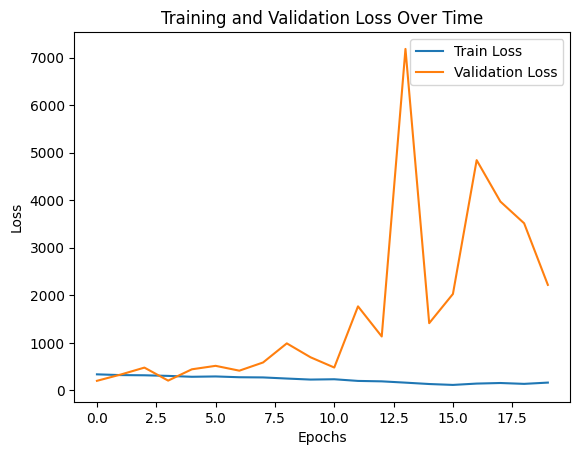

In [17]:
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.show()

In [18]:
# Instantiate the dataset
train_dataset = SalesDataset(df_val)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Parameters
num_shops = df_val['shop_id'].max() + 1        # Example: total unique shops
num_items = df_val['item_id'].max() + 1       # Example: total unique items
num_categories = df_val['item_category_id'].max() + 1    # Example: total unique categories

# Instantiate the model
model = SalesPredictionModel(num_shops, num_items, num_categories, embedding_size, dropout_rate=dropout_rate)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)


In [19]:
num_epochs = 33

history = {
    'train_loss': []
}

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch in train_loader:
        shop_ids, item_ids, category_ids, sales_arrays, targets = batch

        optimizer.zero_grad()
        predictions = model(shop_ids, item_ids, category_ids, sales_arrays)
        loss = criterion(predictions, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    history['train_loss'].append(running_loss / len(train_loader))    
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {running_loss/len(train_loader):.2f} \
[rmse: {np.sqrt(running_loss/len(train_loader)):.2f}]')

Epoch [1/33], Train Loss: 203.99 [rmse: 14.28]
Epoch [2/33], Train Loss: 192.22 [rmse: 13.86]
Epoch [3/33], Train Loss: 186.20 [rmse: 13.65]
Epoch [4/33], Train Loss: 197.23 [rmse: 14.04]
Epoch [5/33], Train Loss: 185.63 [rmse: 13.62]
Epoch [6/33], Train Loss: 195.68 [rmse: 13.99]
Epoch [7/33], Train Loss: 189.02 [rmse: 13.75]
Epoch [8/33], Train Loss: 175.86 [rmse: 13.26]
Epoch [9/33], Train Loss: 169.07 [rmse: 13.00]
Epoch [10/33], Train Loss: 178.70 [rmse: 13.37]


KeyboardInterrupt: 

In [20]:
df_test_raw = pd.read_csv(".data/test.csv", index_col=[0]).assign(date_block_num=34, item_cnt_month=np.nan)
df_test_vectors = transform_data_to_features(pd.concat([test_split_featurized, df_test_raw]), 35)
df_test = df_test_vectors.merge(pd.read_csv(".data/items.csv")[['item_id', 'item_category_id']], on='item_id', how='left')

/var/folders/nn/v5bcwy852z121w7pz8m7sypr0000gn/T/ipykernel_28409/2025639828.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  padded_seqs = df.groupby(["shop_id", "item_id"]) \


In [21]:
test_dataset = SalesDataset(df_test)

In [22]:
preds = []

model.eval()
with torch.no_grad():
    for i in range(len(test_dataset)):
        elem = (_.unsqueeze(0) for _ in test_dataset[i])
        shop_ids, item_ids, category_ids, sales_arrays, _ = elem

        predictions = model(shop_ids, item_ids, category_ids, sales_arrays)
        preds.append(predictions.item())

In [23]:
df_submission = df_test_raw \
    .reset_index()[['ID', 'shop_id', 'item_id']] \
    .merge(
        df_test.assign(predictions=preds)[['shop_id', 'item_id', 'predictions']], 
        on=['shop_id', 'item_id'], 
        how='left'
    )[['ID', 'predictions']] \
    .rename(columns={'predictions': 'item_cnt_month'})

In [27]:
df_submission['item_cnt_month'] = df_submission['item_cnt_month'].clip(0, 20)

In [28]:
df_submission.to_csv(".data/submission_lstm2.csv", index=False)